<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -*- coding: utf-8 -*-
"""
MOOC Dropout Prediction using XGBoost + GridSearchCV
"""

# ------------------------------
# Import Required Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

# ------------------------------
# Step 1: Load and Preprocess Data
# ------------------------------
def load_data():
    # Load CSV files
    enrollment = pd.read_csv("enrollment_train.csv")
    logs = pd.read_csv("log_train.csv")
    truth = pd.read_csv("truth_train.csv", header=None, names=['enrollment_id', 'label'])

    # Convert time column to datetime
    logs['time'] = pd.to_datetime(logs['time'])

    # Merge enrollment info
    logs = logs.merge(enrollment, on='enrollment_id', how='left')

    # Compute day since enrollment
    logs['start_time'] = logs.groupby('enrollment_id')['time'].transform('min')
    logs['day'] = (logs['time'] - logs['start_time']).dt.days
    logs = logs[(logs['day'] >= 0) & (logs['day'] < 30)]  # Limit to first 30 days

    # Define behavior categories
    behaviors = ['access', 'problem', 'discussion', 'navigate', 'video', 'wiki', 'page_close']
    enrollment_ids = enrollment['enrollment_id'].unique()
    eid_to_index = {eid: idx for idx, eid in enumerate(enrollment_ids)}
    behavior_to_index = {b: i for i, b in enumerate(behaviors)}

    # Initialize tensor [#enrollments x 30 days x 7 behaviors]
    feature_tensor = np.zeros((len(enrollment_ids), 30, len(behaviors)), dtype=np.float32)

    # Fill tensor with counts of behaviors per day
    for _, row in logs.iterrows():
        if row['event'] in behavior_to_index:
            i = eid_to_index[row['enrollment_id']]
            d = row['day']
            j = behavior_to_index[row['event']]
            feature_tensor[i, d, j] += 1

    # Build label array
    labels = np.array([
        truth[truth['enrollment_id'] == eid]['label'].values[0]
        for eid in enrollment_ids
    ])

    return feature_tensor, labels, behaviors



In [6]:
# ------------------------------
# Step 2: Flatten Time Series Features
# ------------------------------
def flatten_features(X, behaviors):
    stats = []
    feature_names = []

    for i, behavior in enumerate(behaviors):
        data = X[:, :, i]
        stats.append(data.sum(axis=1))            # Total activity
        stats.append(data.mean(axis=1))           # Mean daily activity
        stats.append(data.std(axis=1))            # Std dev
        stats.append((data > 0).sum(axis=1))      # Number of active days

        feature_names.extend([
            f"{behavior}_sum", f"{behavior}_mean",
            f"{behavior}_std", f"{behavior}_active_days"
        ])

    return np.stack(stats, axis=1), feature_names

# ------------------------------
# Step 3: Train XGBoost with GridSearchCV

Starting grid search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

=== Evaluation Results on Test Set ===
Accuracy : 0.800655356920652
Precision: 0.8010993657505285
Recall   : 0.994645107097858
F1 Score : 0.8874420347557263


<Figure size 1200x600 with 0 Axes>

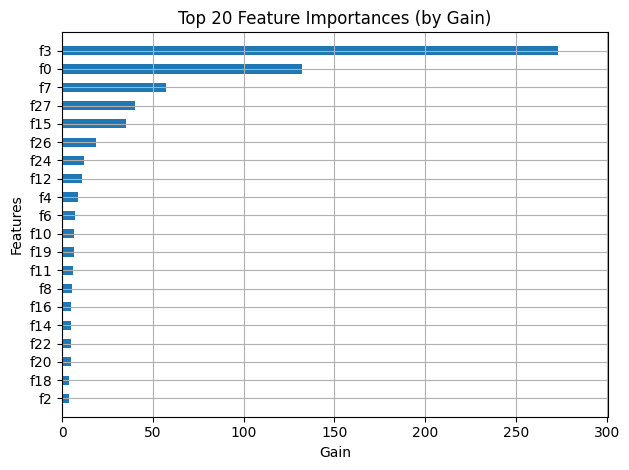

In [7]:

    # Load and process
    X_ts, y, behaviors = load_data()
    X, feature_names = flatten_features(X_ts, behaviors)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Define XGBoost model
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Define grid for hyperparameter search
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1]
    }

    # Run GridSearchCV with 3-fold cross-validation
    print("Starting grid search...")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid_search = GridSearchCV(
            estimator=xgb,
            param_grid=param_grid,
            scoring='f1',
            cv=3,
            verbose=1,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

    # Retrieve the best model
    best_model = grid_search.best_estimator_
    print("Best parameters found:", grid_search.best_params_)

    # Evaluate the best model
    y_pred = best_model.predict(X_test)
    print("\n=== Evaluation Results on Test Set ===")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))

    # Plot top 20 features by gain
    plt.figure(figsize=(12, 6))
    plot_importance(best_model, importance_type='gain', max_num_features=20,
                    show_values=False, height=0.5, xlabel="Gain")
    plt.title("Top 20 Feature Importances (by Gain)")
    plt.tight_layout()
    plt.show()


In [9]:
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Step 8: Save the best model
    joblib.dump(best_model, "best_xgboost_model.pkl")
    print("✔️ Best model saved as 'best_xgboost_model.pkl'.")

    # Step 9: Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Dropout", "Dropout"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


IndentationError: unexpected indent (ipython-input-9-2187717036.py, line 5)